In [59]:
# %matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

## Funciones generales

In [60]:
#Da el espectro identificando los primeros máximos sin analizar
def Spectrum(datax,datay,intensity,num):
    marker_x = []
    marker_y = []
    index_y = []
    index_x = []
    anotaciones = []

    for i in range(0,len(datax)):
        mark = i

        if mark != 0 and mark != len(datax)-1:
            last = datay[mark - 1]
            next = datay[mark + 1]

            #Hallar máximos de espectro
            if (last < datay[i]) and (next < datay[i]) and (datay[i]>intensity):
                marker_x.append(datax[i])
                marker_y.append(datay[i])

                index_y.append( datay[i-num:i+num] )
                index_x.append( datax[i-num:i+num] )

                anotaciones.append(str(datax[i]))
                
    return marker_x,marker_y,index_x,index_y,anotaciones


#Procesa el archivo txt de datos, inten se refiere a la intensidad mínima para buscar y num a la cantidad de puntos alrededor de la lorentziana
def DataProcess(l,inten,num):
    data = pd.read_csv(l, delimiter=' ')
    pixel = np.array(data['P'])
    intensidad = np.array(data['I'])

    marker_x,marker_y, index_x,index_y,anotaciones = Spectrum(pixel,intensidad,inten,num)
    
    return pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones


#Retira aquellas líneas que no aparecen en el catálogo o no ayudan a la obtención de la lorentziana
def DataCatalogue(pixs,marker_x,marker_y, index_x,index_y,anotaciones):
    mar_x = []
    mar_y = []
    ind_y = []
    ind_x = []
    anot = []
   

    for i in range(0,len(marker_x)):
        if marker_x[i] not in pixs:
            mar_x.append(marker_x[i])
            mar_y.append(marker_y[i])
            ind_x.append(index_x[i])
            ind_y.append(index_y[i])
            anot.append(anotaciones[i])

    return mar_x,mar_y, ind_x,ind_y,anot


#Función Lorentziana
def Lorentzian(x,h,x0,W):
    return h*W**2/((x-x0)**2+W**2)


#Realiza el ajuste Lorentziano sobre el espectro catalogado
def AjusteLorentz(i,index_x, index_y):
    x = index_x[i]
    y = index_y[i] 
    x_1 = np.linspace(x[0],x[-1],500 )

    popt, _ = curve_fit(Lorentzian,x,y) 
    h = popt[0]
    x0 = popt[1]
    w = popt[2]

    fit_y= Lorentzian(x_1,h,x0,w)

    return x0,h,fit_y,x_1, x, y


#Devuelve el DataFrame con los píxeles calculados
def MakeDataFrame(rango,catalog_long,index_x, index_y):

    Datafit = pd.DataFrame()
    lineasfit = []
    alturafit = []

    for i in range(0,rango):
        linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x, index_y)
        lineasfit.append(linea)
        alturafit.append(altura)
    

    Datafit['Pixel'] = lineasfit
    Datafit['Intensidad'] = alturafit
    Datafit['Catalogo longitud'] = catalog_long

    return Datafit

#Obtener la regresion lineal
def LinearFit(datax,datay,n):
    param = np.polyfit(datax,datay, n)
    xm = np.linspace(min(datax),max(datax),len(datax))
    ym = np.polyval(param, xm)
    xres = datax
    ye = np.polyval(param, datax)
    res = ye - datay

    return ym,xm,res,xres,param

#Obtener la calibración de las lineas sospechosas
def LineasSus(pixs,param):
    Data = pd.DataFrame()
    Data['Pixel'] = pixs
    Orden1 = []
    Orden2 = []
    Orden3 = []
    for i in pixs:
        Orden1.append(np.polyval(param,i)*2)
        Orden2.append(np.polyval(param,i)) 
        Orden3.append(np.polyval(param,i)*(2/3)) 
    
    Data['Calibracion orden 1'] = Orden1
    Data['Calibracion orden 2'] = Orden2
    Data['Calibracion orden 3'] = Orden3

    return Data

#Convertir DataFrame a tabla de Latex
# print(DataFit_1.to_latex(index=False))

# Linea para guardar la imagen de un fig
#fig2.savefig('th 6200 orden 2 espectro tratado.jpg')

## Análisis

### Para intensidades grandes > 810

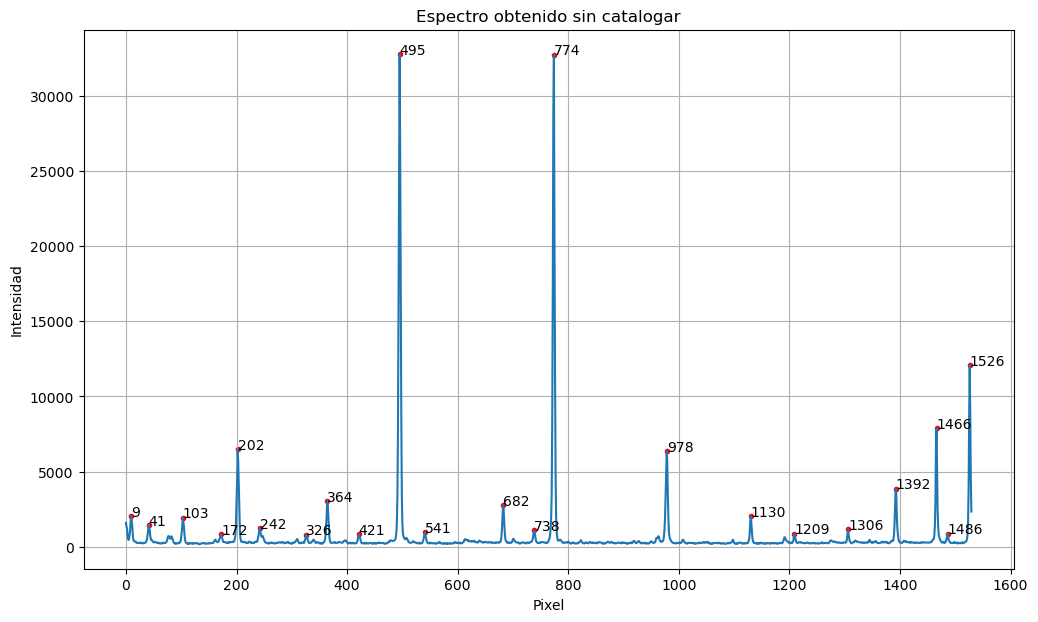

In [61]:
pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6520\th 6520 orden 2 spec.txt", 810, 7)

#Grafica para ver el espectro completo y cuadrar hasta qué intensidad mirar
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x,marker_y,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))

Aquellas líneas identificadas de la imagen 6565 del espectro fueron 242, 169 a ser respectivamente 1466 y 1392, con longitudes de onda de 6554.16, 6551.70.

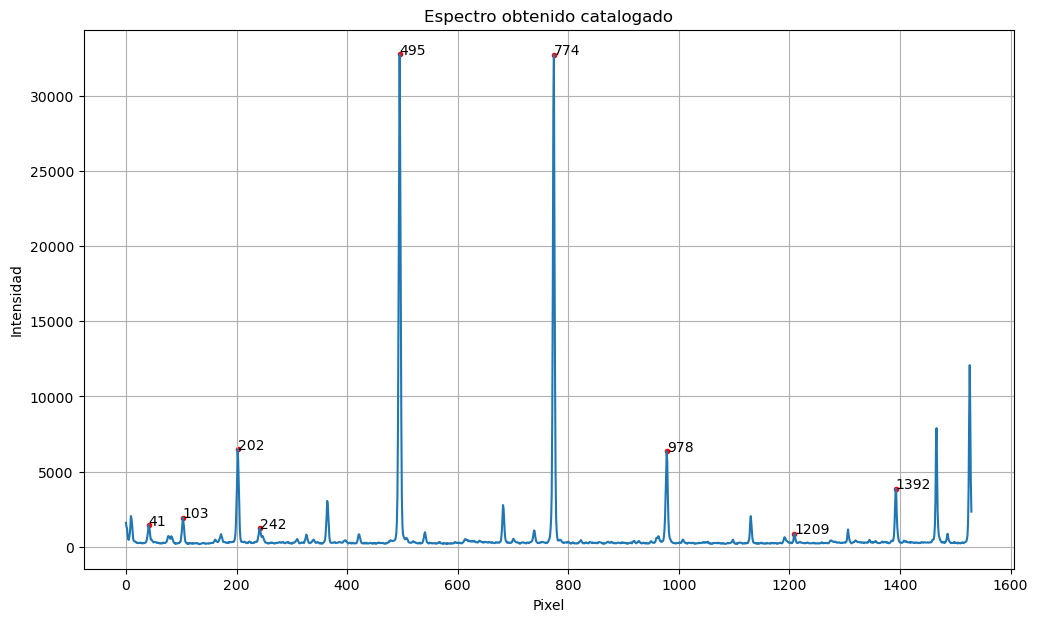

In [62]:
#Lista de pixeles que se descartan al no estar en el espectro
Pixnon_1 = [9, 172, 326, 364, 421, 541, 682, 738, 1130, 1306, 1486, 1466, 1526]

#Se obtiene el espectro limpio sin los píxeles diferentes
marker_xl,marker_yl, index_xl,index_yl,anotacionesl = DataCatalogue(Pixnon_1,marker_x,marker_y, index_x,index_y,anotaciones)
    
#Grafica del espectro sin las líneas que no pertenecen  
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_xl,marker_yl,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotacionesl):
    plt.annotate(label, (marker_xl[i] + 0.1, marker_yl[i]))


In [63]:
#Longitudes de onda observadas en el catalogo de los píxeles que sí se lograron ver, ingreso manual
catalog_long_1 = [6506.985, 6509.049, 6512.364, 6513.840, 6522.043, 6531.340, 6538.115, 6545.718, 6551.705]

#Lista de líneas sospechosas que sí están en el espectro pero no catalogadas
Pixesp_1 = [172]

#Lista de líneas completamente sospechosas 
Pixsus_1 = [9, 364, 421, 541, 682, 738, 1130, 1306, 1486]

#Unir dataframes de líneas en el catalogo
DataFit_1 = MakeDataFrame(len(marker_xl),catalog_long_1,index_xl, index_yl)
DataFit_1

,Pixel,Intensidad,Catalogo longitud
0,41.513538,1372.650649,6506.985
1,103.223371,1912.553628,6509.049
2,202.413503,6644.932532,6512.364
3,242.544577,1090.204292,6513.840
4,495.050186,33858.401070,6522.043
5,773.671770,35027.450941,6531.340
6,978.089462,6591.805119,6538.115
7,1209.092861,779.132767,6545.718
8,1392.402248,4109.794971,6551.705


### Para líneas con intensidades pequeñas < 810

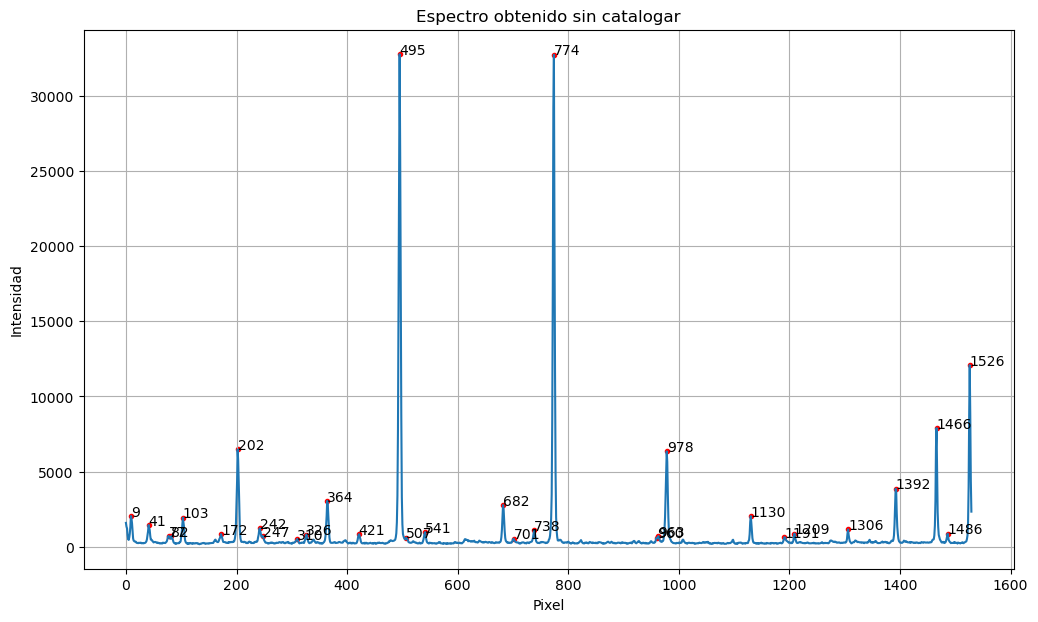

In [64]:
pixel,intensidad,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6520\th 6520 orden 2 spec.txt", 510, 7)

#Grafica para ver el espectro completo y cuadrar hasta qué intensidad mirar
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x_,marker_y_,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones_):
    plt.annotate(label, (marker_x_[i] + 0.1, marker_y_[i]))

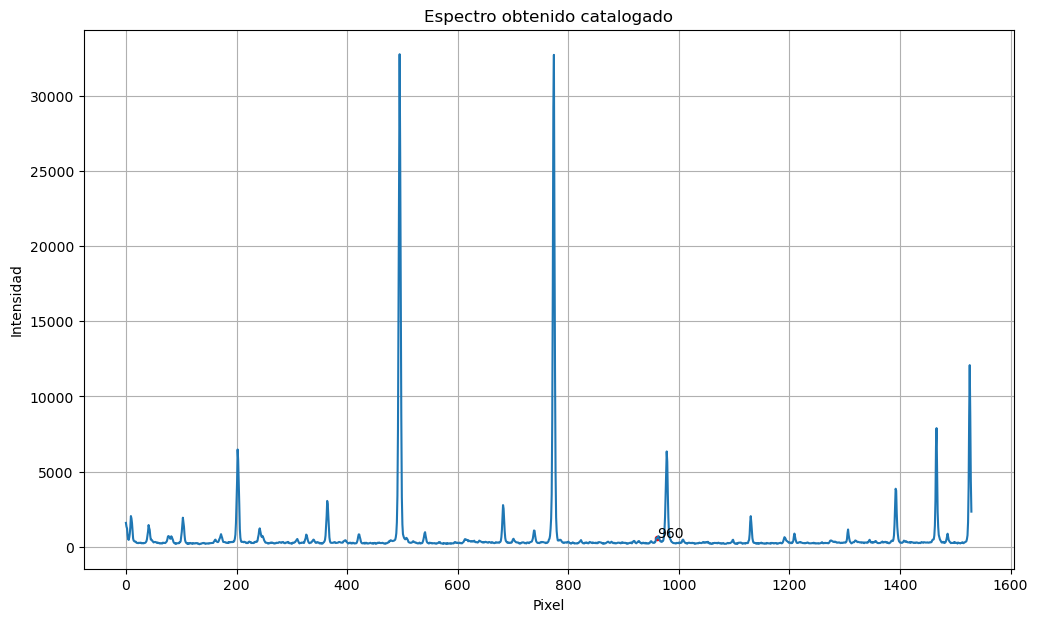

In [65]:
#Lista de pixeles que se descartan al no estar en el espectro
Pixnon_2 = [41, 77, 82, 103, 202,242, 247, 310, 326, 364, 421, 495, 507, 701, 774, 963, 978, 1130, 1191, 1209, 1306, 1392, 1466, 1486, 1526]

#Se obtiene el espectro limpio sin los píxeles diferentes
marker_xl_,marker_yl_, index_xl_,index_yl_,anotacionesl_ = DataCatalogue(Pixnon_2 + Pixnon_1,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)
    
#Grafica del espectro sin las líneas que no pertenecen  
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_xl_,marker_yl_,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotacionesl_):
    plt.annotate(label, (marker_xl_[i] + 0.1, marker_yl_[i]))


In [66]:
#Longitudes de onda observadas en el catalogo de los píxeles que sí se lograron ver, ingreso manual
catalog_long_2 = [6537.614]

#Lista de líneas sospechosas que sí están en el espectro pero no catalogadas
Pixesp_2 = [77, 1191]

#Lista de líneas completamente sospechosas 
Pixsus_2 = [310, 326, 701]

#Unir dataframes de líneas en el catalogo
DataFit_2 = MakeDataFrame(len(marker_xl_),catalog_long_2,index_xl_, index_yl_)
DataFit_2

,Pixel,Intensidad,Catalogo longitud
0,962.021614,652.794883,6537.614


#### Lineas para analizar individualmente

In [67]:
# #NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
# pixsus = [] 

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt",275,10)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

# catalog_long_2 = []
# DataFit_21 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# DataFit_21

#### Lineas especiales

In [68]:
# # Solo descomentar si es necesario un análisis con gráfica para ver el ajuste
# pixsus = [] #lineas ya analizadas

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt",275,18)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)


# def MakeDataFrame(rango,catalog_long,index_x_,index_y_):

#     Datafit = pd.DataFrame()
#     lineasfit = []
#     alturafit = []

#     for i in range(0,rango):
#         linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x_,index_y_)
#         lineasfit.append(linea)
#         alturafit.append(altura)
    

#     Datafit['Pixel'] = lineasfit
#     Datafit['Intensidad'] = alturafit
#     Datafit['Catalogo longitud'] = catalog_long

#     return Datafit, fity, fitx, x, y

# catalog_long_2 = []
# DataFit_2, fity, fitx, x, y = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(x,y)

### Unir todo en un dataframe

In [69]:
DataFit = pd.concat([DataFit_1,DataFit_2], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)
DataFit

,Pixel,Intensidad,Catalogo longitud
0,41.513538,1372.650649,6506.985
1,103.223371,1912.553628,6509.049
2,202.413503,6644.932532,6512.364
3,242.544577,1090.204292,6513.840
4,495.050186,33858.401070,6522.043
5,773.671770,35027.450941,6531.340
6,962.021614,652.794883,6537.614
7,978.089462,6591.805119,6538.115
8,1209.092861,779.132767,6545.718
9,1392.402248,4109.794971,6551.705


### Gráfica del espectro con las líneas encontradas 

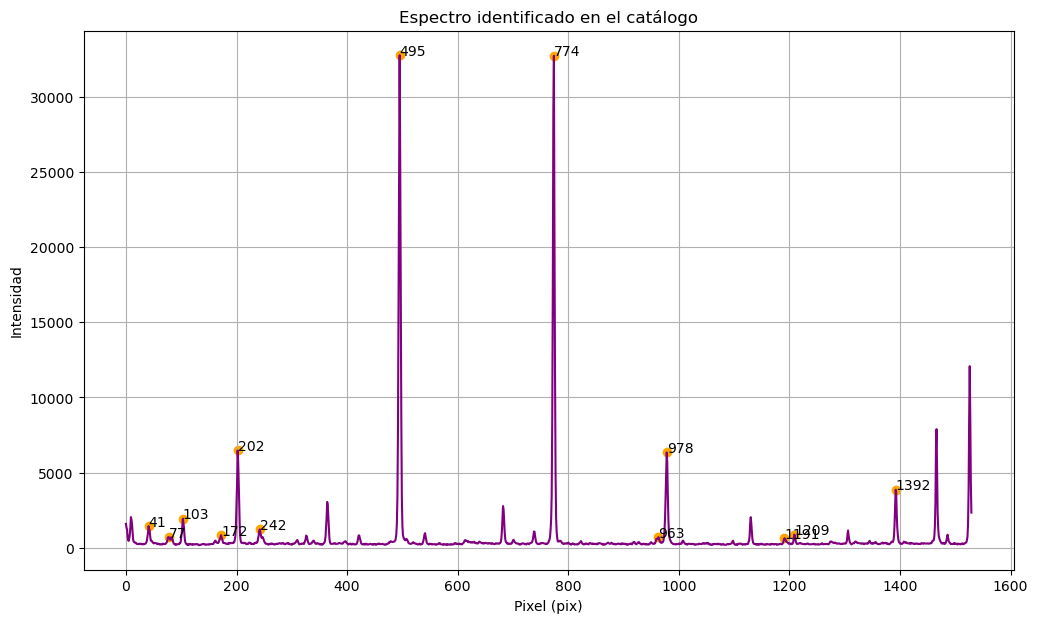

In [70]:
#Solo utilizar al final cuando ya se esté segura del análisis
Pixnon =  [9, 82, 247, 310, 326, 364, 421, 507, 541, 682, 701, 738, 960,1130, 1306, 1466, 1486, 1526]

pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6520\th 6520 orden 2 spec.txt", 510, 7)
markerx,markery, indexx,indexy,anotaciones = DataCatalogue(Pixnon ,marker_x,marker_y, index_x,index_y,anotaciones)

#Grafica con aquellas encontradas
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.plot(pixel,intensidad, color='purple')
ax.scatter(markerx,markery,color = 'orange')
ax.set_title('Espectro identificado en el catálogo')
ax.set_xlabel('Pixel (pix)')
ax.set_ylabel('Intensidad')
ax.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (markerx[i] + 0.1, markery[i]))

#fig.savefig('th 6520 espectro tratado.pdf')

### Regresión lineal de todos los puntos

[-1.26613239e-12  3.53025470e-09 -3.34683620e-06  3.43669537e-02
  6.50555847e+03]


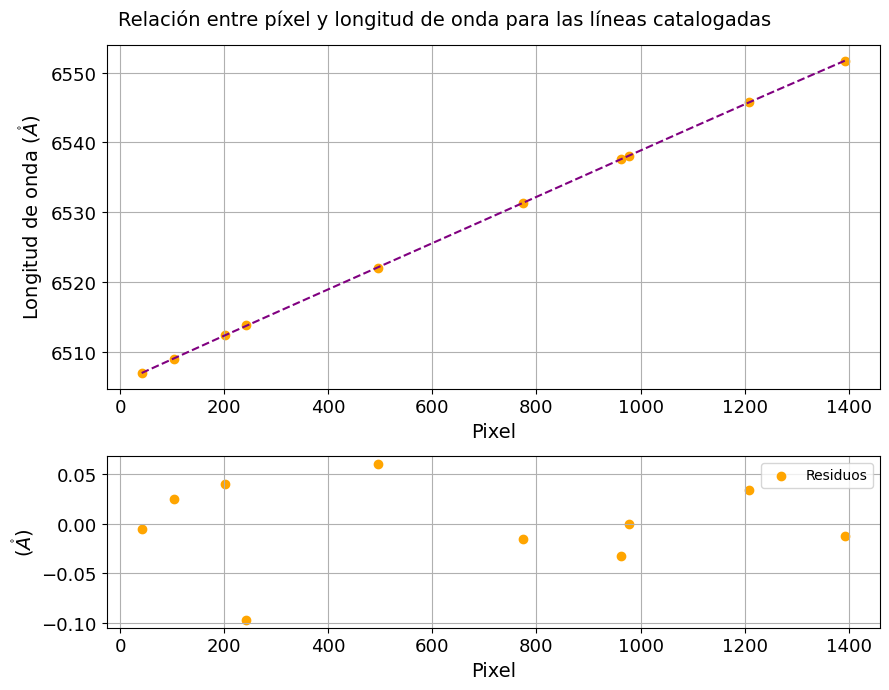

In [71]:
ym,_x,res,xres,param = LinearFit(DataFit['Pixel'],DataFit['Catalogo longitud'], 4) 

#Gráfico con residuos
fig3, axis3 = plt.subplots(2,1, figsize = (9, 7), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis3[0]
ax2 = axis3[1]

fig3.suptitle(r'Relación entre píxel y longitud de onda para las líneas catalogadas',fontsize=14)

ax1.scatter(DataFit['Pixel'],DataFit['Catalogo longitud'], color='orange')
ax1.plot(_x,ym,'--',color='purple')
ax1.set_ylabel(r"Longitud de onda $(\mathring{A})$",fontsize=14)
ax1.set_xlabel(r'Pixel',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(xres,res,label = 'Residuos',color='orange')
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)
ax2.legend()
ax2.set_xlabel(r'Pixel',fontsize=14)
ax2.set_ylabel(r'$(\mathring{A})$',fontsize=14)

fig3.tight_layout()
#fig3.savefig('th 6520 regresion lineal.pdf')
print(param)

### Análisis líneas sospechosas

In [72]:
#Ver y tener los diferentes valores encontrados en el catalogo de nist
LineasSos_1 = LineasSus(Pixsus_1,param)
LineasSos_2 = LineasSus(Pixsus_2 ,param)

LineasSos = pd.concat([LineasSos_1,LineasSos_2], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)

LineasSos['Catalogo longitud orden 1'] = [13011.6305, 13031.1251, None,None, 13039.2682,None, 13048.1362,13056.0997,13058.023,None,None, None]
LineasSos['Elemento orden 1'] = ['Fe II', 'Th I', None,None, 'Th I',None, 'Th I','Th I','Th I',None,None,None]
LineasSos['Residuos orden 1'] = LineasSos['Calibracion orden 1'] - LineasSos['Catalogo longitud orden 1']
LineasSos['Catalogo longitud orden 3'] = [4337.27726,4343.95142,4344.32657,4345.168,4346.41315,4349.07214,4352.1863,4352.61213,4353.4006,4362.0660,4365.93001,4369.87567]
LineasSos['Elemento orden 3'] = ['Th I','Th II','Th II','Ar I','Th I','Th I','Th II','Th I','Th II','Ar II','Th I','Th I']
LineasSos['Residuos orden 3'] = LineasSos['Calibracion orden 3'] - LineasSos['Catalogo longitud orden 3']

LineasSos

,Pixel,Calibracion orden 1,Calibracion orden 2,Calibracion orden 3,Catalogo longitud orden 1,Elemento orden 1,Residuos orden 1,Catalogo longitud orden 3,Elemento orden 3,Residuos orden 3
0,9,13011.735015,6505.867508,4337.245005,13011.6305,Fe II,0.104515,4337.27726,Th I,-0.032255
1,310,13031.968150,6515.984075,4343.989383,13031.1251,Th I,0.843050,4343.95142,Th II,0.037963
2,326,13033.028842,6516.514421,4344.342947,NaN,None,NaN,4344.32657,Th II,0.016377
3,364,13035.545268,6517.772634,4345.181756,NaN,None,NaN,4345.16800,Ar I,0.013756
4,421,13039.314824,6519.657412,4346.438275,13039.2682,Th I,0.046624,4346.41315,Th I,0.025125
5,541,13047.243925,6523.621963,4349.081308,NaN,None,NaN,4349.07214,Th I,0.009168
6,682,13056.571950,6528.285975,4352.190650,13048.1362,Th I,8.435750,4352.18630,Th II,0.004350
7,701,13057.830809,6528.915405,4352.610270,13056.0997,Th I,1.731109,4352.61213,Th I,-0.001860
8,738,13060.283691,6530.141846,4353.427897,13058.0230,Th I,2.260691,4353.40060,Th II,0.027297
9,1130,13086.297909,6543.148955,4362.099303,NaN,None,NaN,4362.06600,Ar II,0.033303


In [73]:
# Por si se necesita quitar algun elemento None del dataframe .drop([2],axis=0).reset_index(drop=True)
LineasSos['Longitud catálogo'] = LineasSos['Catalogo longitud orden 3']
LineasSos['Elemento'] = LineasSos['Elemento orden 3']
LineasSos['Longitud Calculada'] = LineasSos['Calibracion orden 3']
LineasSos = LineasSos.drop(['Residuos orden 1','Residuos orden 3','Catalogo longitud orden 1','Catalogo longitud orden 3', 'Calibracion orden 1', 'Calibracion orden 3','Elemento orden 1','Elemento orden 3', 'Calibracion orden 2'], axis=1)

LineasSos
#Código para imprimir la tabla de latex
print(LineasSos.to_latex(index=False))

\begin{tabular}{rrlr}
\toprule
Pixel & Longitud catálogo & Elemento & Longitud Calculada \\
\midrule
9 & 4337.277260 & Th I & 4337.245005 \\
310 & 4343.951420 & Th II & 4343.989383 \\
326 & 4344.326570 & Th II & 4344.342947 \\
364 & 4345.168000 & Ar I & 4345.181756 \\
421 & 4346.413150 & Th I & 4346.438275 \\
541 & 4349.072140 & Th I & 4349.081308 \\
682 & 4352.186300 & Th II & 4352.190650 \\
701 & 4352.612130 & Th I & 4352.610270 \\
738 & 4353.400600 & Th II & 4353.427897 \\
1130 & 4362.066000 & Ar II & 4362.099303 \\
1306 & 4365.930010 & Th I & 4365.942441 \\
1486 & 4369.875670 & Th I & 4369.765050 \\
\bottomrule
\end{tabular}



In [74]:
#Lineas que aparecen en el espectro y no son sospechosas
LineasSos_1_ = LineasSus(Pixesp_1,param)
LineasSos_2_ = LineasSus(Pixesp_2,param)
LineasSos_ = pd.concat([LineasSos_1_,LineasSos_2_], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)
LineasSos_['Longitud Calculada'] = LineasSos_['Calibracion orden 2'] 
LineasSos_ = LineasSos_.drop(['Calibracion orden 2', 'Calibracion orden 1', 'Calibracion orden 3'],axis=1)

LineasSos_

#Código para imprimir la tabla de latex
print(LineasSos_.to_latex(index=False))

\begin{tabular}{rr}
\toprule
Pixel & Longitud Calculada \\
\midrule
77 & 6508.186453 \\
172 & 6511.387432 \\
1191 & 6545.158572 \\
\bottomrule
\end{tabular}



### Revisar residuos de lineas sospechosas

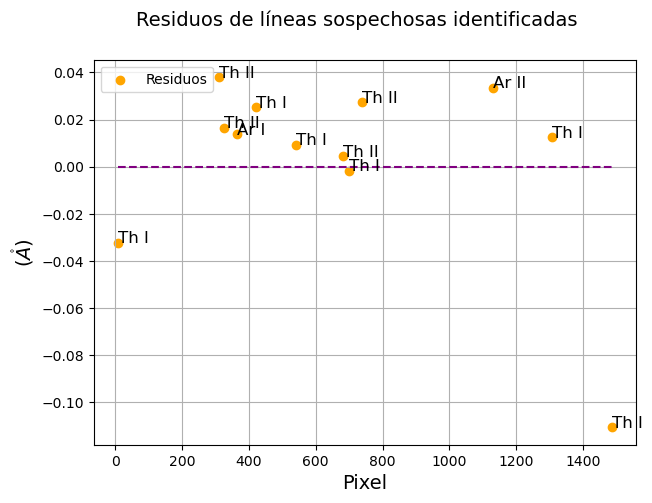

In [75]:
#Calcular residuos de las líneas sospechosas
nist = LineasSos['Longitud catálogo']
calc = LineasSos['Longitud Calculada']
residuos = calc - nist

pixel = LineasSos['Pixel']

#Etiquetas de elementos
label = [each for each in LineasSos['Elemento']]

#Gráfico con residuos
figr, axr = plt.subplots(1,1, figsize=(7,5))

figr.suptitle(r'Residuos de líneas sospechosas identificadas',fontsize=14)

axr.scatter(pixel,residuos,label = 'Residuos',color='orange')
axr.plot(pixel,np.linspace(0,0,len(residuos)),'--',color='purple')
axr.grid()
axr.legend()
axr.set_xlabel(r'Pixel',fontsize=14)
axr.set_ylabel(r'$(\mathring{A})$',fontsize=14)

for j in range (0, len(label)):
    plt.annotate(label[j], (pixel[j], residuos[j]),fontsize=12)

#figr.savefig('th 6520 residuos.pdf')